**comment about this approach**

*model-free* - We don’t require an explicit model of the environment’s dynamics (i.e. we don’t predefine state transition probabilities or a reward function that predicts future states). Instead, the agent learns solely from the rewards and state transitions it experiences while interacting with the TSP environment. This is the hallmark of a model‑free approach.

*off-policy* - Off‑policy learning means that the algorithm learns the optimal policy independently of the policy used to generate the data (the behavior policy). In our DQL approach, this is evident in how the Q‑values are updated:

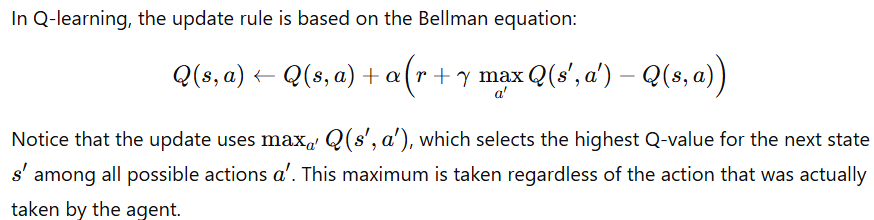

A model-free RL algorithm can be thought of as an "explicit" trial-and-error algorithm.

Meanwhile, the *on-policy* update would look like that:

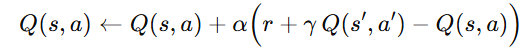

In [2]:
import numpy as np
import random
import math
from collections import namedtuple, deque

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Device configuration (note: the code is not fully optimized for GPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#############################################
# Helper functions (from your starter code)
#############################################
def get_graph_mat(n=10, size=1):
    """Creates n nodes randomly in a square and returns the (n,2) coordinates and (n,n) distance matrix."""
    coords = size * np.random.uniform(size=(n, 2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat

def plot_graph(coords):
    """Plots the fully connected graph."""
    n = len(coords)
    plt.scatter(coords[:, 0], coords[:, 1], s=[50 for _ in range(n)])
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i, 0], coords[j, 0]], [coords[i, 1], coords[j, 1]], 'b', alpha=0.7)
    plt.show()


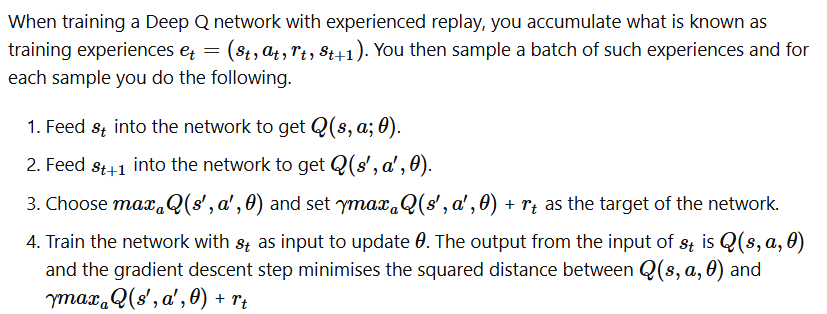

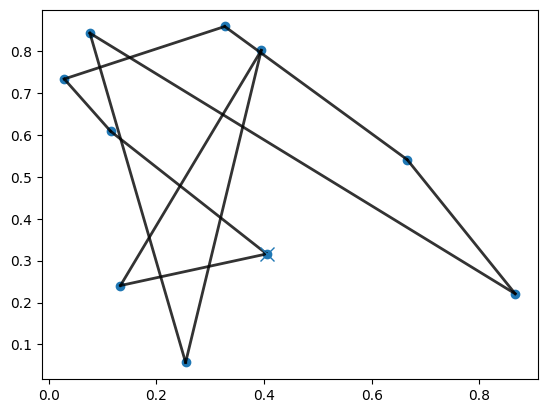

Episode 1/50, Total Reward: -5.28, Epsilon: 0.90
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Greedy Solution (node order): [0, 4, 9, 8, 2, 5, 3, 1, 6, 7]


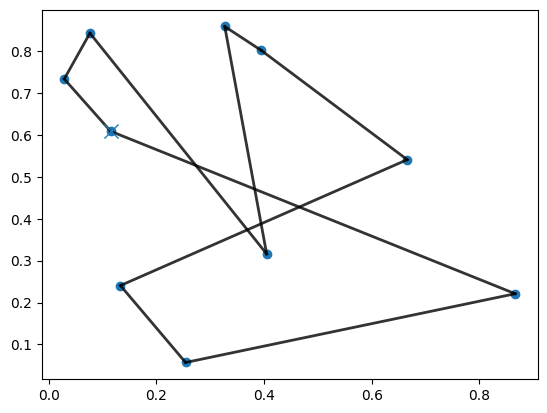

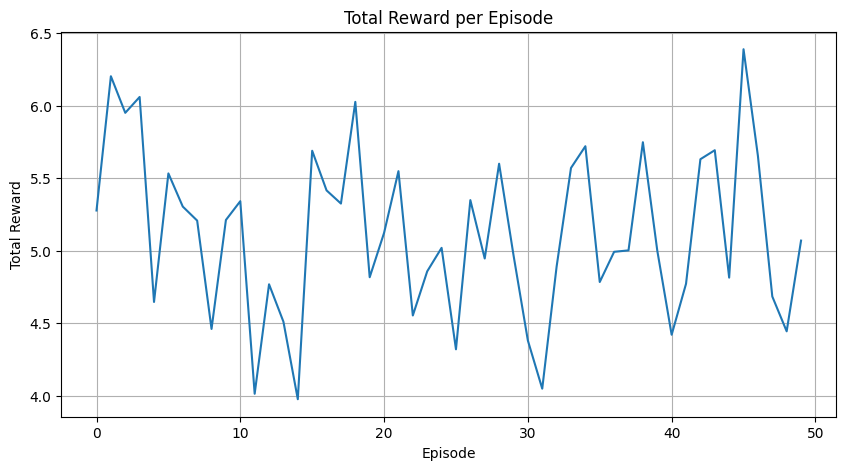

Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])
Q-values: torch.Size([10])


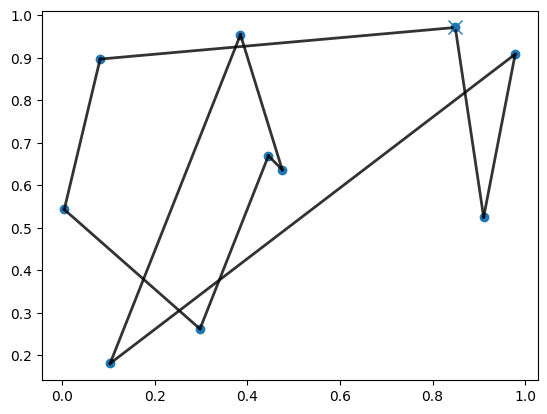

In [3]:
# The state contains the full distance matrix, node coordinates, and the current tour (partial_solution)
State = namedtuple('State', ('W', 'coords', 'partial_solution'))

def state2tens(state: State) -> torch.Tensor:
    """
    Convert a State into a (N, 5) tensor where for each node we store:
      - Whether it is already in the tour.
      - Whether it is the first node.
      - Whether it is the last visited node.
      - Its x-coordinate.
      - Its y-coordinate.
    """
    solution = set(state.partial_solution)
    sol_last_node = state.partial_solution[-1] if state.partial_solution else -1
    sol_first_node = state.partial_solution[0] if state.partial_solution else -1
    coords = state.coords
    nr_nodes = coords.shape[0]
    xv = [[1 if i in solution else 0,
           1 if i == sol_first_node else 0,
           1 if i == sol_last_node else 0,
           coords[i, 0],
           coords[i, 1]]
          for i in range(nr_nodes)]
    return torch.tensor(xv, dtype=torch.float32, device=device)

#############################################
# Define the Q-Network (a simple MLP)
#############################################
class QNetwork(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            # nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            # nn.Dropout(0.4),
            # nn.LayerNorm(hidden_dim),
            # nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1) # (N, 1) -> (N,)

#############################################
# Replay Memory for Experience Replay
#############################################
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        """Save a transition."""
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size) -> list[Transition]:
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

#############################################
# Environment Step and Policy Functions
#############################################
def step(state: State, action: int):
    """
    Given a state and an action (choosing the next city), compute:
      - The immediate reward (negative distance traveled).
      - The next state.
      - Whether the episode is done (i.e. the tour is complete).
    When the tour is complete, we add the cost to return to the starting city.
    """
    current_city: int = state.partial_solution[-1]
    reward: float = - state.W[current_city, action]
    new_partial: list[int] = state.partial_solution + [action]
    done = False
    if len(new_partial) == state.W.shape[0]:
        # Completed tour; add cost for returning to the starting city.
        reward += - state.W[action, state.partial_solution[0]]
        done = True
    next_state: State = State(state.W, state.coords, new_partial)
    return next_state, reward, done

def select_action(state: State, policy_net, epsilon: float):
    """
    Selects the next action using an epsilon-greedy policy. Valid actions are the cities not
    already in the partial solution. Returns the index of the selected (max) action.
    """
    valid_actions = list(set(range(state.coords.shape[0])) - set(state.partial_solution))
    if random.random() < epsilon:
        return random.choice(valid_actions)
    else:
        with torch.no_grad():
            state_tensor = state2tens(state) # shape: (nr_nodes, node_dim)
            # print(f"State tensor: {state_tensor}")
            q_values = policy_net(state_tensor) # state tensor contains all nodes embeddings at time t
            # print(f"Q-values: {q_values}")
            # print(f"Potential mask: {state_tensor[:, 0].bool()}")
            mask = state_tensor[:, 0].bool() # mask out visited nodes
            # Mask out already visited nodes by assigning them -infinity.
            q_values_masked = q_values.masked_fill(mask, -float('inf'))
            # print(f"Masked Q-values: {q_values_masked}")
            action = q_values_masked.argmax().item() # return an index of the max value (it's action aka node label)
        return action

def optimize_model(memory, policy_net, target_net, optimizer, batch_size, gamma):
    """
    Samples a batch from replay memory and performs one optimization step.
    The target is computed using the target network.
    """
    if len(memory) < batch_size:
        return
    
    transitions = memory.sample(batch_size)

    batch_s = [t[0] for t in transitions]
    batch_a = [t[1] for t in transitions]
    batch_r = [t[2] for t in transitions]
    batch_next_s = [t[3] for t in transitions]
    batch_done = [t[4] for t in transitions]

    # Convert states to tensors in a single pass
    s_tensors = torch.stack([state2tens(s) for s in batch_s]) # shape: (batch_size, nr_nodes, node_dim)
    q_vals = policy_net(s_tensors)  # shape: (batch_size, nr_nodes)

    # Gather Q-values for each chosen action
    actions_tensor = torch.tensor(batch_a, dtype=torch.long, device=device)
    chosen_q_vals = q_vals[range(batch_size), actions_tensor]

    # Build target values
    target_vals = []
    with torch.no_grad():
        next_s_tensors = torch.stack([state2tens(ns) for ns in batch_next_s]) # shape: (batch_size, nr_nodes, node_dim)
        q_next_all = target_net(next_s_tensors)  # shape: (batch_size, nr_nodes)
        for i in range(batch_size):
            if batch_done[i]:
                target_vals.append(batch_r[i])
            else:
                # Clone and mask visited nodes
                # q_next_masked = q_next_all[i].clone()
                # for node in batch_next_s[i].partial_solution:
                #     q_next_masked[node] = -float('inf')
                q_next_masked = q_next_all[i].clone()
                mask = torch.zeros_like(q_next_masked, dtype=torch.bool)
                mask[batch_next_s[i].partial_solution] = True
                q_next_masked = q_next_masked.masked_fill(mask, -float('inf'))

                target_vals.append(batch_r[i] + gamma * q_next_masked.max().item())

    targets_tensor = torch.tensor(target_vals, dtype=torch.float32, device=device)

    # Compute loss
    loss = F.mse_loss(chosen_q_vals, targets_tensor)

    ####################################################################

    # loss = 0.0
    # for trans in transitions:
    #     s, a, r, next_s, done = trans
    #     s_tensor = state2tens(s)
    #     q_val = policy_net(s_tensor)[a]  
    #     if done:
    #         target = torch.tensor(r, dtype=torch.float32, device=device)
    #     else:
    #         next_s_tensor = state2tens(next_s)
    #         q_next = target_net(next_s_tensor)
    #         # Mask out visited nodes in next state.
    #         q_next_masked = q_next.clone()
    #         for idx in next_s.partial_solution:
    #             q_next_masked[idx] = -float('inf')
    #         target = torch.tensor(r, dtype=torch.float32, device=device) + gamma * q_next_masked.max() # r + gamma * max_a' Q(s', a')
    #     loss += F.mse_loss(q_val, target)
    # loss = loss / batch_size


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#############################################
# Main Training Loop for DQL on TSP
#############################################
def train_tsp_dql(coords, W, num_episodes=500, batch_size=32, gamma=0.95, 
                  epsilon_start=0.9, epsilon_end=0.05, epsilon_decay=200,
                  target_update=10, memory_capacity=10000):
    """coords: (n, 2) array of node coordinates, W: (n, n) distance matrix."""

    
    # A helper to reset the environment: here we fix the starting city to 0.
    def reset():
        return State(W, coords, [0])
    
    policy_net = QNetwork().to(device)
    target_net = QNetwork().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.AdamW(policy_net.parameters(), lr=1e-3)
    memory = ReplayMemory(memory_capacity)
    
    episode_rewards = []
    
    for episode in range(num_episodes):
        state = reset()
        total_reward = 0.0
        
        # Epsilon decays over episodes.
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-episode / epsilon_decay)
        done = False
        while not done:
            action = select_action(state, policy_net, epsilon)
            next_state, reward, done = step(state, action)
            total_reward += reward
            memory.push(state, action, reward, next_state, done)
            state = next_state
            
            optimize_model(memory, policy_net, target_net, optimizer, batch_size, gamma)
            
        
        episode_rewards.append(total_reward)
        
        # Update the target network periodically.
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if episode % 50 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")
    
    return policy_net, episode_rewards

#############################################
# Testing and Plotting the Greedy Solution
#############################################
def get_greedy_solution(policy_net, W, coords):
    """Extracts a tour by always choosing the best action (epsilon=0)."""
    state = State(W, coords, [0])
    solution = state.partial_solution.copy()
    done = False
    while not done:
        with torch.no_grad():
            state_tensor = state2tens(state)
            q_values = policy_net(state_tensor)
            print(f"Q-values: {q_values.shape}")
            q_values_masked = q_values.clone()
            for idx in state.partial_solution:
                q_values_masked[idx] = -float('inf')
            action = q_values_masked.argmax().item()
        state, reward, done = step(state, action)
        solution.append(action)
    return solution

def plot_rewards(episode_rewards):
    """Plot the total rewards over episodes."""
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards)
    plt.title('Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

def plot_solution(coords, solution):
    plt.scatter(coords[:,0], coords[:,1])
    n = len(coords)
    
    for idx in range(n-1):
        i, next_i = solution[idx], solution[idx+1]
        plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    
    i, next_i = solution[-1], solution[0]
    plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], 'x', markersize=10)
    plt.show()


#############################################
# Run the Training and Test the Solution
#############################################
if __name__ == '__main__':
    # For reproducibility.
    random.seed(43)
    np.random.seed(43)
    torch.manual_seed(43)
    
    n_cities = 10
    # Generate a random TSP instance.
    coords, W_np = get_graph_mat(n=n_cities)
    rand_sol = list(range(n_cities))
    random.shuffle(rand_sol)
    plot_solution(coords, rand_sol)

    num_episodes = 50  # Adjust the number of episodes as needed.
    policy_net, reward_history = train_tsp_dql(coords, W_np, num_episodes=num_episodes)
    
    solution = get_greedy_solution(policy_net, W_np, coords)
    print("Greedy Solution (node order):", solution)
    plot_solution(coords, solution)
    plot_rewards([-reward for reward in reward_history])

    # create a graph of the same size to check generalization (wtf, why it generalizes so well?)
    unseen_coords, unseen_W_np = get_graph_mat(n=n_cities)
    unseen_graph_sol = get_greedy_solution(policy_net, unseen_W_np, unseen_coords)
    plot_solution(unseen_coords, unseen_graph_sol)
